In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os

import sklearn.linear_model as linear_models
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, TimeSeriesSplit

import xgboost as xgb
import sklearn.model_selection as ms

In [3]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = target_df.join(predictor_df)
df = df.sort_index(ascending=False)
df.dropna(inplace=True)

In [35]:
df.index[:10]

DatetimeIndex(['2021-02-28', '2021-02-27', '2021-02-26', '2021-02-25',
               '2021-02-24', '2021-02-23', '2021-02-22', '2021-02-21',
               '2021-02-20', '2021-02-19'],
              dtype='datetime64[ns]', name='USAGE_DATE', freq=None)

In [48]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

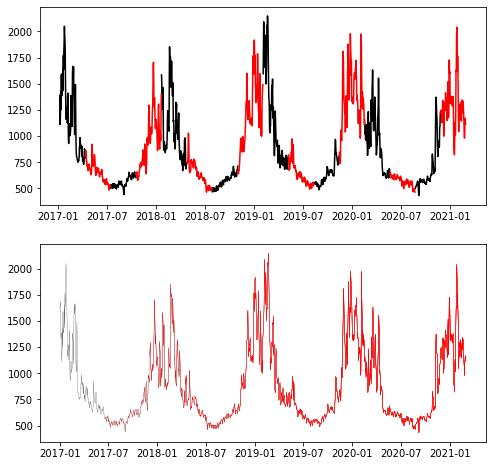

In [66]:
plt.figure(figsize=(8,8))

tscv = BlockingTimeSeriesSplit(n_splits=8)
for test_index, train_index in tscv.split(df.index):
    X_train, X_test = df.index[train_index], df.index[test_index]
    Y_train, Y_test = df.iloc[train_index]['SoCal_TOTAL'], df.iloc[test_index]['SoCal_TOTAL']
    plt.subplot(2,1,1)
    plt.plot(X_train, Y_train, 'k')
    plt.plot(X_test, Y_test, 'r')

tscv = TimeSeriesSplit(n_splits=8)
for test_index, train_index in tscv.split(df.index):
    X_train, X_test = df.index[train_index], df.index[test_index]
    Y_train, Y_test = df.iloc[train_index]['SoCal_TOTAL'], df.iloc[test_index]['SoCal_TOTAL']
    plt.subplot(2,1,2)
    plt.plot(X_train, Y_train, 'k', linewidth=.2)
    plt.plot(X_test, Y_test, 'r', linewidth=.2)
    

DatetimeIndex(['2021-02-28', '2021-02-27', '2021-02-26', '2021-02-25',
               '2021-02-24', '2021-02-23', '2021-02-22', '2021-02-21',
               '2021-02-20', '2021-02-19',
               ...
               '2018-01-25', '2018-01-24', '2018-01-23', '2018-01-22',
               '2018-01-21', '2018-01-20', '2018-01-19', '2018-01-18',
               '2018-01-17', '2018-01-16'],
              dtype='datetime64[ns]', name='USAGE_DATE', length=1139, freq=None)

In [4]:
region = 'SoCal' # can be SD or SoCal
target = df[region + '_TOTAL']

predictor_dict = \
{'set_1': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
               'Sat','Sun','Holiday'],
'set_2': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', 
               'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
               'Sat','Sun','Holiday'],
'set_3': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'day_of_year_sine', 'day_of_year_cosine',
               'Sat','Sun','Holiday'],
'set_4': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD',
                 region+'_HDD_7', region + '_t-1_HDD_7',
               'day_of_year_sine', 'day_of_year_cosine',
               'Sat','Sun','Holiday'],
'set_5': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'month_sine', 'month_cosine',
               'Sat','Sun','Holiday'],
'set_6': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD',
                 region+'_HDD_7', region + '_t-1_HDD_7',
               'month_sine', 'month_cosine',
               'Sat','Sun','Holiday'],
}

In [22]:
params = {} # dictionary of best parameters 
evaluation_df = pd.DataFrame() # dataframe of evaluation metrics
for key, value in predictor_dict.items(): 
    
    xgb_model = xgb.XGBRegressor()
    predictors = df[value]
    # hyperparameter tuning for XGBoost 
    params = {
            'learning_rate'  : [0.10, 0.20, 0.30 ], #increasing value decreases computation time but possibly accuracy
            'min_child_weight': [3, 5, 8, 10], # larger = more conservative
            'gamma': [0.5, 1, 1.5, 2, 5], # loss reduction threshold to make a split. larger =  more conservative
            'colsample_bytree': [0.6, 0.75, 0.9], # %data to sample per tree. Smaller proportion of data = reduce overfitting
            'max_depth': [3, 4, 5, 6, 7] # % max depth of each tree. Shallower tree depth = reduce overfitting
            }

    xgb_grid = ms.GridSearchCV(xgb_model, param_grid=params, 
                             scoring='neg_mean_absolute_error', verbose=3 ) #default is 5-fold CV
    xgb_grid.fit(predictors, target)
    
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'explained_variance']
    xgb_scores = cross_validate(xgb_grid.best_estimator_, predictors, target, cv=5, scoring = scoring)
    
    analyses = dict(zip(scoring, [np.mean(xgb_scores['test_' + metric]) for metric in scoring]))
    analyses_df = pd.DataFrame.from_dict(analyses, orient='index').transpose()
    analyses_df.index = [key]
    evaluation_df = pd.concat([evaluation_df, analyses_df])
    params.update({key: xgb_grid.best_params_})

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-20.280, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-28.799, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-27.704, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.149, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-23.755, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-21.429, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-28.723, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-26.365, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.283, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-20.251, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-18.762, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-26.044, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-30.551, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-28.454, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.595, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-20.403, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-18.421, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-25.462, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.766, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.153, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.940, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-22.650, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-20.237, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-20.278, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-26.282, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-27.707, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-24.659, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6,

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-22.001, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-19.551, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-28.210, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-30.700, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-27.809, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-26.304, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-25.200, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-21.230, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-27.138, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-33.857, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5,

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-30.220, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-27.065, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-21.250, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-18.894, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-30.656, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-29.436, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-28.854, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-28.917, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-23.283, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-20.611, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.074, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.640, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.362, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-19.971, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-24.545, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-30.062, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-28.035, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-21.356, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-21.516, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-29.563, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-26.246, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-21.691, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-19.841, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-26.689, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-29.584, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-26.623, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-22.572, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-20.977, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-26.807, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-27.119, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-22.231, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-21.424, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-28.342, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-34.006, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-25.086, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-21.867, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-19.753, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-28.053, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-32.950, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-24.681, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-22.353, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-20.280, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-28.799, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-27.704, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.149, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, lea

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-28.429, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-23.388, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-18.883, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-25.416, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-28.712, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5,

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-29.968, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-29.097, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-21.843, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-19.362, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.818, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-29.517, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-26.682, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-22.472, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-19.582, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.766, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-29.363, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.520, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-21.622, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-20.110, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-26.282, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-24.377, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-29.305, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-27.155, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-22.001, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-19.551, total=   0.1s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.178, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-31.403, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-26.304, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-25.200, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-20.595, total=   0.2s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-26.665, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-30.092, total=   0.4s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-25.416, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-21.250, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-18.759, total=   0.2s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-29.436, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-28.854, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-28.917, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-23.283, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-20.611, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.766, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.074, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.640, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.362, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-19.971, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-24.628, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-30.062, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-28.035, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-21.356, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-21.516, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-29.068, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-26.246, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-21.691, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-19.842, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-26.509, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-30.490, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-26.623, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-22.572, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-21.426, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-27.163, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-26.729, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-22.231, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-21.424, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-27.619, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-34.006, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, 

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-26.397, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-21.867, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-18.671, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-28.075, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-32.950, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, 

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-25.098, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-22.353, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-20.280, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-28.799, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-27.439, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-28.429, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-23.388, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-18.883, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-25.417, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-28.711, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-28.592, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-21.843, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-19.784, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.589, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-27.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-22.473, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-19.583, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.766, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.162, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.940, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-21.622, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-21.155, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-27.898, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-28.661, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-24.518, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-22.001, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-19.551, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-28.210, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-30.700, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-27.809, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-25.200, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-20.438, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-27.756, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-34.044, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-29.383, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-22.230, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-18.839, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-30.000, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-31.092, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-25.063, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-19.131, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-27.557, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-29.095, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-29.248, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-22.898, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-21.480, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-17.015, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-25.804, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-28.633, total=   0.4s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-25.555, total=   0.3s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-28.590, total=   0.5s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-20.284, total=   0.5s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-18.129, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-26.619, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-28.311, total=   0.5s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-28.436, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-28.950, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-28.114, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-24.012, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-19.484, total=   0.3s
[CV] colsample_bytree=0.

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-21.031, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-24.663, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-27.170, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-27.925, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-20.463, total=   0.3s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-19.785, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-28.868, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-30.215, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-28.012, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-25.089, total=   0.2s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-21.398, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-21.894, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-26.153, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-34.188, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-24.296, total=   0.2s
[CV] colsample_bytree=0

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-26.112, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-20.455, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-22.653, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-25.563, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-29.185, total=   0.3s
[CV] colsample_bytree=0.7

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-29.729, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-24.354, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-20.145, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-26.636, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-28.935, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-26.884, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-20.633, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-20.659, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-23.881, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-28.637, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-29.715, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-27.776, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-20.932, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-18.823, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-27.939, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-24.074, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-29.353, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-27.717, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-22.385, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-21.042, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-25.737, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-28.122, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-26.081, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-22.275, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-21.443, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-26.560, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-31.709, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-27.196, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-19.677, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-21.565, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-27.619, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-32.028, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-25.595, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-20.499, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-21.253, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-27.199, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-29.277, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-31.590, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-24.805, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-22.397, total=   0.2s
[CV] colsample_bytree=0.75, g

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-19.997, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-23.893, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-28.085, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-28.867, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-20.572, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-18.761, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-19.966, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-22.961, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-29.140, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-26.806, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-26.479, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-21.624, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-20.074, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-27.616, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-30.087, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-31.443, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-23.061, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-21.094, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-22.557, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-25.072, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-29.178, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-28.355, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-23.784, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-19.972, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-29.538, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-24.967, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-30.762, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-27.222, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-19.207, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-22.070, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-25.278, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-27.181, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-31.063, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-29.034, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-21.383, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-20.542, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-24.227, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-27.962, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-29.521, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-22.917, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-19.802, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-26.643, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-29.155, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-27.305, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-20.333, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-19.015, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-26.247, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-31.058, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-28.663, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-23.069, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-20.717, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-23.632, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-29.180, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-25.214, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-20.286, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-21.153, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-26.210, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-28.250, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-24.901, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-18.999, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-20.916, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-27.880, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-27.979, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-27.835, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-18.849, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-20.584, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-28.064, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-31.397, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-25.298, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-19.597, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-21.406, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-28.970, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-29.168, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-30.960, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-24.258, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-18.848, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-26.776, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-29.577, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-27.559, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-20.049, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-18.188, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-27.093, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-28.846, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-25.891, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-18.605, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-19.200, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-27.311, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-30.163, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-26.027, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-21.624, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-21.093, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-24.738, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-30.993, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-23.061, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-19.641, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-20.345, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-29.167, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-29.178, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-28.355, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-23.784, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-21.838, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-27.587, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-30.762, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-29.262, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-19.207, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-25.284, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-26.809, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-31.766, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-26.889, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-20.180, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-20.509, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-26.851, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-27.666, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-27.426, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-22.170, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-19.146, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-19.478, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-23.672, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-26.149, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-24.591, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-29.833, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-22.792, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-18.784, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-26.365, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-28.906, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-28.719, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-26.920, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-21.372, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-20.991, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-25.728, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-26.448, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-28.521, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-27.018, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-20.515, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-19.219, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-26.099, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-30.656, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-28.040, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-21.299, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-20.841, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-20.006, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-28.588, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-28.984, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-25.714, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-20.541, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-21.147, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-21.189, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-28.189, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-27.674, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.173, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, 

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-24.210, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-19.282, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-24.779, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.772, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.375, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, ma

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-21.941, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-18.360, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.192, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-28.387, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-23.683, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, ma

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-18.876, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-24.740, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.664, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.217, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-23.784, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-19.597, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-26.264, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-31.039, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-28.001, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-22.685, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-27.932, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-32.728, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-26.360, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-23.323, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-21.999, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-27.721, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-29.476, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-27.544, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-21.480, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-20.863, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-28.615, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-28.702, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-26.743, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-21.530, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-22.279, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-27.810, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-26.388, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-27.289, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-22.444, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-20.509, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-18.800, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-25.227, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-27.283, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-24.625, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-19.146, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-22.139, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-17.274, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-28.477, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-29.560, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-29.833, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, l

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-26.429, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-23.947, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-19.902, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-24.479, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-28.718, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5,

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-30.779, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-27.317, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-22.246, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-18.969, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-26.359, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-33.280, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-28.042, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-22.207, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-18.815, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-26.099, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-25.440, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-30.836, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-25.677, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-19.956, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-20.473, total=   0.2s
[CV] colsample_bytree=0.9, gamma=

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-21.467, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-25.955, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-30.456, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-28.647, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-21.147, total=   0.2s
[CV] colsample_bytree=0.9, gamm

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-20.787, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-26.177, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-27.873, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-29.014, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-23.803, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-19.169, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-23.529, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-28.511, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-27.972, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-21.941, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-30.742, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-30.410, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-31.599, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-23.356, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-18.876, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-24.514, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-30.251, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-27.208, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-22.000, total=   0.5s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-19.699, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-25.793, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-31.470, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-27.485, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-21.088, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-20.185, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-29.782, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-26.143, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-21.750, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-21.324, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-27.721, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-30.344, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-25.112, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-20.319, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-20.484, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-27.929, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-29.745, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-30.806, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-24.778, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-18.644, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-26.694, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.418, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.993, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-21.989, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-18.800, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-25.186, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-27.490, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-27.186, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-22.139, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-17.274, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-29.461, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-29.824, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-26.429, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-23.947, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-20.249, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-24.479, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-30.779, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-27.317, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-22.246, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-19.722, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-26.408, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-28.042, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-22.207, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-18.815, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-26.099, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-30.656, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, 

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-25.678, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-19.956, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-19.073, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-26.887, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-29.763, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, 

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-28.647, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-20.771, total=   0.2s


[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 16.2min finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-22.316, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.636, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-31.094, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-32.862, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-25.763, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-22.305, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-29.148, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-30.441, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.502, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-28.827, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-22.869, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-20.189, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-29.559, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-29.039, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-30.257, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-26.088, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-21.537, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-20.148, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.777, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-31.037, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-26.811, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-21.962, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-21.135, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-24.185, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-29.664, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-31.597, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-25.345, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-21.297, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-21.401, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-21.409, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-26.956, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-31.735, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-23.746, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.104, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-21.579, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-21.834, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-30.416, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-35.372, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5,

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-35.645, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-25.792, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-20.508, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-21.780, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-30.052, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-29.545, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-32.727, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-25.564, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-19.946, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-28.036, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-31.336, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.183, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.584, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-20.119, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-29.972, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-29.090, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-25.273, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-23.802, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-20.712, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-29.687, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-26.874, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-23.356, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-21.571, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-29.260, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-30.762, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-25.544, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-23.358, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-22.239, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-28.824, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-32.361, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-26.955, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-22.373, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-21.455, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-29.985, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.350, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-25.175, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-21.795, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-23.411, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-30.016, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-31.739, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-27.142, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-21.916, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-22.316, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.635, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-31.094, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learn

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-28.729, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-28.135, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-25.401, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-20.009, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-29.641, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.161, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-25.636, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-22.939, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-20.640, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-29.039, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-30.408, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-28.080, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-25.504, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-21.050, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.777, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-29.141, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-31.991, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.625, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-21.165, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-24.185, total=   0.2s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-30.542, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-32.025, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-26.385, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-21.401, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-21.409, total=   0.1s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-22.849, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-30.836, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.697, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.104, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-21.579, total=   0.1s
[CV] colsample_bytree=0.6, gamm

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-20.104, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-24.053, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-29.583, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-35.645, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-25.792, total=   0.2s
[CV] colsample_bytree=0.6, gamma

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-23.211, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-28.121, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-29.545, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-32.727, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-25.564, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.848, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-31.336, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.183, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.584, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-20.119, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-28.546, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-29.090, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-25.273, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-23.802, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-20.712, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-33.393, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-26.874, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-23.356, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-22.769, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-29.260, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-32.572, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-25.544, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-23.359, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-22.221, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-29.073, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-34.055, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-26.955, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-22.375, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-21.455, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-29.985, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-30.506, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-25.175, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-21.795, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-22.919, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-30.106, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3

[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-27.142, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-21.916, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-22.316, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.635, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weigh

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-28.135, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-25.401, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-20.009, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-29.122, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.502, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-25.636, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-22.939, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-20.020, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-28.795, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-29.107, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-28.080, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-25.502, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-21.050, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.777, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-30.854, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, 

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-21.165, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-22.606, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-30.223, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-33.113, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-24.880, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-22.258, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-21.409, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-26.956, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-32.253, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-23.746, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-21.579, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-22.101, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-29.251, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-33.629, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-25.972, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-21.160, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-22.434, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-31.270, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-32.749, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-28.369, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-27.646, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-20.443, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-26.854, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-30.714, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-28.710, total=   0.1s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-26.976, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.561, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-21.475, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-28.946, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-28.642, total=   0.2s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-30.755, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-26.989, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-22.631, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-22.073, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-28.255, total=   0.1s
[CV] colsample_bytree=0.75

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-30.149, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-29.079, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-24.035, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-22.769, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-28.597, total=   0.2s
[CV] colsample_bytree=0.75

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-29.430, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-32.596, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-26.438, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-23.312, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-22.163, total=   0.2s
[CV] colsample_bytree=0.

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-23.789, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-29.376, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-36.915, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-26.207, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-22.969, total=   0.1s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-23.987, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-29.004, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-31.920, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-26.027, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-22.388, total=   0.2s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-27.689, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-21.697, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-24.422, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-29.644, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-33.188, total=   0.2s
[CV] colsample_bytree=0.7

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-29.566, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-24.893, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-22.638, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-27.808, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.222, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-29.726, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-26.964, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-22.050, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-21.913, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-28.844, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-28.533, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-21.411, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-23.134, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-32.186, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-33.724, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-22.273, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-23.174, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-29.374, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-29.908, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.252, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, lear

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-26.164, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-21.654, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-25.260, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-29.507, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-32.608, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-28.614, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-23.260, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-24.161, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-31.267, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-35.840, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-24.808, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-21.770, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-23.428, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-32.087, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-35.726, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-30.268, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-27.134, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-23.765, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-26.467, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-31.315, total=   0.1s
[CV] colsample_bytree=0.7

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-27.003, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-23.588, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-22.424, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.343, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.428, total=   0.2s
[CV] colsample_bytree=0.7

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-28.538, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-28.095, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-21.738, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-21.895, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-29.096, total=   0.2s
[CV] colsample_bytree=0.75,

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-33.293, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-27.797, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-24.311, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-21.222, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-30.642, total=   0.2s
[CV] colsample_bytree=0.75,

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-29.653, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-32.586, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-26.335, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-22.208, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-22.468, total=   0.2s
[CV] colsample_bytree=0.75, g

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-28.242, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-34.540, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-27.818, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-22.164, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-23.789, total=   0.1s
[CV] colsample_bytree=0.75, g

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-21.259, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-24.297, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-29.483, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-34.696, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-26.816, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-26.001, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-23.095, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-24.780, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-30.508, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-33.230, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-24.827, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-21.433, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-28.380, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-31.718, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-29.566, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-26.626, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-21.491, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-21.518, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-25.703, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-29.726, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-22.961, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-23.106, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-27.813, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-33.050, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-28.533, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-22.849, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-28.927, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-30.307, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-27.970, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-22.273, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-24.450, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-29.988, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-32.452, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-26.164, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-21.654, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-24.693, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-29.464, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-35.066, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-28.614, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-23.260, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-29.331, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-33.240, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-24.808, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-21.770, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-23.428, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_r

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-29.130, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-32.201, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-30.268, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-27.134, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-23.765, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_r

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-21.784, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-27.663, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-30.664, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-27.003, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-23.588, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-21.750, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-26.218, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-28.538, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-28.095, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-21.738, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-31.052, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-33.293, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-27.797, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-24.311, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-21.224, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_r

[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-29.653, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-32.029, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-27.361, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-21.988, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_chil

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-28.242, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-34.540, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-27.818, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-22.164, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-23.789, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_r

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-29.483, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-34.696, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-26.816, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-22.484, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-23.989, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_r

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-30.508, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-33.305, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-27.149, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-21.734, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-24.670, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_r

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-20.447, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-27.661, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-29.979, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-28.573, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-25.175, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-21.082, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-21.180, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-27.957, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-29.581, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-26.291, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-25.024, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-21.590, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-26.714, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-33.868, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-29.322, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-26.447, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-21.731, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-22.337, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-26.888, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-31.454, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-33.019, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-27.766, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-20.622, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-22.413, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-28.099, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-26.818, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-31.604, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-28.245, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-22.408, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-23.259, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-22.079, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-30.075, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-31.840, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-28.233, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-21.728, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-28.924, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-30.968, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-31.483, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-25.750, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-21.312, total=   0.5s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-27.058, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-29.800, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-26.704, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-22.228, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=8,

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-28.187, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-30.083, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-24.864, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-20.962, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-21.258, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-27.167, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-30.551, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-27.320, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-22.012, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-22.511, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-29.752, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-27.982, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-21.270, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-22.253, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=8,

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-27.247, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-22.663, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-24.516, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-27.259, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-34.898, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-21.840, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-24.719, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-25.636, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-32.090, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-26.483, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-20.629, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-23.700, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-27.656, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-34.718, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-24.954, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-23.023, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-20.447, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-27.661, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-29.979, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-28.573, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-26.091, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-21.082, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-21.180, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-27.957, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-29.581, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-31.821, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-27.991, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-25.024, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-21.590, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-26.714, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-27.809, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-31.898, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-26.447, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-21.731, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-22.337, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-21.467, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-28.853, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-33.019, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-27.766, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-20.941, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-19.626, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-26.818, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-31.604, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-28.245, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-22.408, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-21.852, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-22.417, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-30.075, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-31.949, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-28.866, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-32.553, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.874, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-22.903, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-28.924, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-30.968, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-26.664, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-24.046, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-20.959, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-27.058, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-29.557, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-24.191, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-20.987, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-21.739, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-27.865, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-30.589, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-25.707, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-22.919, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-21.861, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-27.167, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-30.551, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-27.585, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-20.889, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-22.183, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-27.892, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-29.752, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-26.086, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-21.209, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-21.813, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-28.951, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-35.200, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-28.119, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-20.873, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-21.860, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-26.046, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-30.450, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-28.105, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-20.452, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-22.793, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-29.663, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-33.612, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-24.398, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-22.235, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-26.768, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-30.968, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-28.875, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-22.210, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-20.439, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-28.768, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-30.888, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-26.091, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-22.275, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-27.135, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-31.821, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-27.991, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-25.024, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-20.912, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-27.809, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-31.898, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-26.447, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-21.732, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-21.579, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-28.652, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-33.019, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-27.074, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-20.737, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-26.818, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-31.604, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-27.383, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-22.408, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-23.259, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-29.857, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-31.682, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-29.484, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-20.979, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-21.474, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 13.5min finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-19.346, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.431, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.401, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.693, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-18.256, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-18.880, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-28.532, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-27.789, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-26.558, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-24.015, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-15.693, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-16.709, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-26.427, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-29.095, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.604, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.050, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-15.640, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-17.450, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.321, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.487, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-25.971, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-15.823, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-20.229, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-19.928, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-25.813, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-26.910, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-28.503, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-16.970, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-16.042, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-18.689, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-30.210, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-30.721, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-24.114, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-19.284, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-20.271, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-27.607, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-28.034, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-25.083, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-26.721, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-17.268, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-18.646, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-29.530, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-30.211, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5,

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-17.962, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-16.352, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-27.652, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-25.703, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-25.683, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-17.770, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-28.125, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-26.234, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-25.554, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-15.774, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-26.588, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-25.296, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-28.580, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-15.941, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-19.357, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-27.378, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-27.659, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-27.314, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-15.262, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-19.308, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-26.806, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-26.064, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-27.123, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-15.604, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-21.524, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-28.622, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-31.771, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-27.445, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-20.307, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-20.322, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-28.888, total=   0.4s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-30.293, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-28.000, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-18.654, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-20.575, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.431, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.401, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.693, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-18.256, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-18.880, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-17.348, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-26.626, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-26.558, total=   0.4s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-24.015, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-15.693, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-16.889, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-18.521, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-28.646, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.604, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-24.732, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, l

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-16.626, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-18.743, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.321, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.487, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-25.971, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, l

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.869, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-15.952, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-20.207, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-25.813, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-26.028, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5,

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-27.390, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-26.994, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-16.042, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-18.689, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-30.210, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.720, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.745, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.812, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-19.284, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-20.271, total=   0.2s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-18.717, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-27.433, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-27.071, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-26.721, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-17.268, total=   0.3s
[CV] colsample_bytree=0.6, gamm

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-17.880, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-18.774, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-29.085, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-28.397, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-26.494, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-15.603, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-17.264, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.669, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-25.960, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-24.807, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-15.897, total=   0.6s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-17.834, total=   0.5s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-28.526, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-27.009, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-24.880, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-15.767, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-19.934, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-29.911, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-26.922, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-26.608, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-15.823, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-21.951, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-28.507, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-26.026, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-25.598, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-17.492, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-27.627, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-29.526, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-24.402, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-16.901, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-19.517, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-26.827, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-28.881, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-27.401, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-18.352, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-21.138, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-26.075, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-29.953, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-27.675, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-17.345, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-17.210, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-28.988, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-26.051, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-26.899, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-16.485, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-17.520, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-27.246, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-25.604, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-23.845, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-16.889, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate

[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-28.104, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-28.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-26.092, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-16.626, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_w

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-21.671, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.291, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.867, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.869, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-15.952, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-22.742, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-26.602, total=   0.4s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-27.390, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-26.994, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-16.042, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate

[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-20.374, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.720, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.745, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.812, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-19.752, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-18.717, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-27.433, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-27.071, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-27.504, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-18.471, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-27.776, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-27.628, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-26.141, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-17.319, total=   0.1s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-15.560, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-17.274, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-26.350, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.002, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.524, total=   0.2s
[CV] colsample_bytree=0

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-22.798, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-15.659, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-17.105, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-26.647, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-26.635, total=   0.3s
[CV] colsample_bytree=0.7

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-27.380, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-25.267, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-15.827, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-18.437, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-28.370, total=   0.2s
[CV] colsample_bytree=0.75,

[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-29.813, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-25.044, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-17.595, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-19.549, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2,

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-28.964, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-26.618, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-25.474, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-15.995, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-21.051, total=   0.2s
[CV] colsample_bytree=0.75, g

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-17.074, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-21.225, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-30.706, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-30.610, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-26.337, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-26.042, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-18.230, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-20.908, total=   0.4s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-28.652, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-29.811, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-26.744, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-24.770, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-17.454, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-16.777, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-27.314, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-24.823, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-24.036, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-15.473, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-18.056, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-26.955, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-28.423, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-25.413, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-16.943, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-18.895, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-29.561, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-27.180, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-28.597, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-25.598, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-16.962, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-19.210, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-25.588, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-29.600, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-22.754, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-18.367, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-19.080, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-20.776, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-27.692, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-28.494, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-24.565, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-16.427, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-18.580, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-28.180, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-28.805, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-26.862, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-16.626, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-19.304, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-27.257, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-28.598, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-25.780, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-18.207, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-17.665, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-29.181, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-26.950, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-24.327, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-16.639, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-15.089, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-17.917, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-27.460, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-26.747, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-24.506, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.661, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-24.577, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-16.398, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-18.827, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-29.031, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-27.921, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-28.108, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-23.105, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-17.207, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-18.650, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-32.734, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-28.947, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-25.953, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-16.062, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-20.402, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-18.085, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-20.081, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-31.275, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-29.847, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-25.866, total=   0.3s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-23.202, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-17.017, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-19.478, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-32.019, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-26.284, total=   0.3s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-27.628, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-26.141, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-17.319, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-17.398, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-28.115, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.002, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.524, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-15.520, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-17.265, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-27.460, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-26.635, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-23.423, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-15.888, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-17.875, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-28.052, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-26.507, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-15.939, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-18.714, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-25.098, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-25.965, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-25.190, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-15.617, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-21.223, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-26.551, total=   0.4s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-27.353, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-16.682, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-16.620, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-26.771, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-28.969, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-25.128, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_ra

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-17.754, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-19.498, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-32.068, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-27.104, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-28.085, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_ra

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-17.575, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-18.998, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.399, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-28.621, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-25.417, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-16.313, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-28.933, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.545, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-25.105, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-14.614, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-17.015, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-27.633, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-27.574, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.029, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-15.243, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.112, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-28.661, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-24.576, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-16.398, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-18.827, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-27.023, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-28.177, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-22.970, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-16.538, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-19.572, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-32.734, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-28.947, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-25.953, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-16.062, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-20.402, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-20.256, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-31.279, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-30.439, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-25.866, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-17.728, total=   0.4s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-19.673, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-32.105, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-26.476, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-28.653, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-18.102, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-17.372, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-28.453, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-26.169, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-24.031, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-15.808, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-16.377, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-18.937, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-26.851, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-26.509, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-23.996, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, l

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-23.765, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-15.485, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-18.922, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-25.770, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-32.305, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5,

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-28.513, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-23.910, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-16.206, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-19.078, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-28.736, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-30.130, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-28.923, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-26.577, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-17.450, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-18.456, total=   0.3s
[CV] colsample_bytree=0.9, gamma=

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-27.794, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-27.918, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-24.873, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-15.353, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-18.825, total=   0.2s
[CV] colsample_bytree=0.9, gamma=

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-20.789, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-28.246, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-29.412, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-23.090, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-14.817, total=   0.2s
[CV] colsample_bytree=0.9, gamm

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-15.985, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-21.916, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-29.910, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-30.203, total=   1.9s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-25.469, total=   0.4s
[CV] colsample_bytree=0.9, gamma

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-15.710, total=   1.5s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-17.215, total=   4.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-27.993, total=   0.7s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-24.764, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-25.400, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-15.195, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-18.911, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-28.514, total=   0.5s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-26.811, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-24.080, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-17.218, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-28.546, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-29.144, total=   0.5s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-25.130, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-17.222, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-18.752, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-28.851, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-30.655, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-23.626, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-17.557, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-20.990, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-29.426, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-29.297, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-25.596, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-17.353, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1, learning_rate

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-19.330, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-28.999, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.159, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-23.665, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-17.572, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-22.242, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-30.559, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-27.880, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-21.907, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-18.545, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-17.801, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-28.297, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-27.962, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-26.751, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-17.835, total=   0.1s
[CV] colsample_bytree=0.9, gamm

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-14.769, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-17.599, total=   0.6s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-26.938, total=   0.6s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-26.546, total=   0.8s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-24.165, total=   0.3s
[CV] colsample_bytree=0.9, gamma

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-22.569, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-15.384, total=   0.5s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-19.434, total=   0.8s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-28.377, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-25.427, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-25.557, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-14.963, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-19.651, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-27.178, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-28.513, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-30.462, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-23.209, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-17.382, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-19.825, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-30.130, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-28.021, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-30.237, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-23.665, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-18.003, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-19.738, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, 

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-19.710, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-32.156, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-29.687, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-26.569, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-16.908, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-16.920, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-21.394, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-30.002, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-28.356, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-25.686, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-15.795, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-16.501, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-28.422, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-26.192, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-24.933, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-15.098, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-18.943, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-27.156, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-26.480, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-25.039, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-17.025, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-18.228, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-27.102, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-30.544, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-23.560, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-14.271, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-20.837, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-28.735, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-29.281, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-22.464, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-16.564, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-19.912, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-28.985, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-29.236, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-24.947, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-15.767, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-21.071, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-29.784, total=   0.5s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-29.647, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-24.103, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-17.349, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-23.016, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-29.475, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-32.273, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-25.615, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-17.464, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-27.300, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-28.865, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-27.714, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-17.893, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-17.311, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-27.652, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-25.717, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-23.922, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-14.769, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-18.359, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-25.414, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-26.234, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-22.965, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-15.384, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-30.192, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-29.499, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-25.557, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-14.963, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-19.651, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, m

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-31.535, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-30.462, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-23.209, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-17.382, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-19.825, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, m

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-30.237, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-23.665, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-18.003, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-19.738, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-27.794, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3,

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-29.687, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-26.569, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-16.908, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-20.789, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-28.246, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3,

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-29.320, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-25.259, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-16.099, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-21.181, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-29.301, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3,

[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 237.2min finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-19.829, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.379, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.425, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-28.862, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-16.315, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-19.807, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-27.891, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-27.538, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-26.464, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-25.452, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-17.321, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-17.907, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-25.935, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-24.198, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.900, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-23.878, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-17.358, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-20.496, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.767, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-26.723, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-25.254, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-16.524, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-20.592, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-22.929, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-30.501, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-27.222, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-25.177, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-18.727, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-15.332, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-20.750, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-29.719, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-28.806, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-27.614, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-26.539, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-18.199, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-22.214, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-29.385, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-27.828, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5,

[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-25.784, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-17.567, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-19.877, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-28.320, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_dept

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-28.146, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-16.295, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-18.400, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-27.993, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-27.842, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.716, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-17.558, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-19.518, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-27.213, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-25.629, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-25.400, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-17.003, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-19.714, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-31.224, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-26.370, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-25.799, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-15.188, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-20.530, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-30.468, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-27.509, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-16.952, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-22.644, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-28.262, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-26.851, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-27.417, total=   0.4s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-22.397, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-29.412, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-26.767, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-26.624, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-17.081, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-20.738, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-30.914, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-26.505, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-28.054, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-15.938, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.379, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.425, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-28.862, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-16.315, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-19.807, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-18.303, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-25.089, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-26.464, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-25.452, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-17.321, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-17.645, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-19.741, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.142, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.900, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-24.754, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, l

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-28.317, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-16.209, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-19.940, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.767, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-26.723, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5,

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.713, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-25.317, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-16.417, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-22.929, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-30.501, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-28.941, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-27.528, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-23.429, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-15.332, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-20.750, total=   0.1s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-22.806, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-28.613, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-28.870, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-26.539, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-18.199, total=   0.2s
[CV] colsample_bytree=0.6, gamm

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-17.165, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-23.580, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-28.741, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-30.827, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-25.784, total=   0.2s
[CV] colsample_bytree=0.6, gamma

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-19.498, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-29.611, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-28.197, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-28.146, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-16.295, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-29.607, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-26.862, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.716, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-17.558, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-19.518, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-26.983, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-25.362, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-25.400, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-17.003, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-19.714, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-26.351, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-25.799, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-15.188, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-20.530, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-30.468, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-25.625, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-25.786, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-16.952, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-22.010, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-28.812, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-29.184, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-28.819, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-17.712, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-22.397, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-29.412, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-29.854, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-24.635, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-16.065, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-20.738, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-31.393, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-28.582, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-24.655, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-16.892, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-19.829, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.379, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-27.542, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-25.046, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-17.420, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-18.303, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-25.088, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-25.609, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-25.142, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-17.645, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-19.472, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.984, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-24.729, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-28.317, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-16.209, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-19.940, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.767, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.713, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-25.317, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-16.417, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-21.816, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-30.593, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-27.739, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-23.456, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-15.332, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-20.750, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-29.719, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-26.539, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-18.199, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-22.214, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-29.332, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-29.125, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, 

[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-16.994, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-20.588, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-27.716, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-29.347, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-17.079, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-18.858, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-27.514, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-28.528, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-25.125, total=   0.2s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-26.873, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-16.087, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-19.597, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-29.161, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-29.168, total=   0.2s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-29.876, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-29.249, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-26.308, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-16.784, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-21.447, total=   0.1s
[CV] colsample_bytree=0.

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-20.013, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-27.740, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-27.585, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-26.526, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-17.774, total=   0.1s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-17.731, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-20.055, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-26.445, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-28.635, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-25.184, total=   0.2s
[CV] colsample_bytree=0

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-28.850, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-16.191, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-20.681, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-31.455, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-33.697, total=   0.1s
[CV] colsample_bytree=0.7

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-31.346, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-29.379, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-26.012, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-16.606, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-22.192, total=   0.2s
[CV] colsample_bytree=0.75, g

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-21.149, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-30.595, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-32.283, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-27.431, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-17.627, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-28.176, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-28.347, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-25.998, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-17.002, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-19.562, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-28.802, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-28.414, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-25.044, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-16.277, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-19.454, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-27.333, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-28.229, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-26.873, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-17.373, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-22.141, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-21.706, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-25.647, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-29.171, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-26.992, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-17.004, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-19.675, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-26.344, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-30.332, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-25.883, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-16.110, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-30.005, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-30.400, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-27.288, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-16.256, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-21.603, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-33.133, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-31.404, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-27.125, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-16.532, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-23.166, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-27.637, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-27.897, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-28.077, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-16.912, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-18.681, total=   0.1s
[CV] colsample_bytree=0.75, g

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-18.868, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-29.462, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-27.772, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-25.555, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-15.989, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-16.253, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-19.929, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-30.308, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-28.904, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-27.037, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-25.993, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-27.085, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-17.669, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-19.885, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-28.273, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-26.848, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-29.663, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-24.803, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-17.000, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-20.387, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-21.434, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-30.175, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-34.186, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-27.116, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-17.041, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-17.766, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-21.648, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-28.783, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-31.079, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-27.898, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-28.792, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-18.049, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-19.865, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-35.003, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-29.828, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-25.125, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-16.572, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-18.209, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-29.349, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-28.376, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-24.460, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-15.425, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-20.100, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-28.743, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-28.654, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-26.890, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-17.502, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-23.407, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-28.195, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-27.339, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-24.809, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-15.779, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-20.744, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-25.344, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-29.206, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-25.700, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-18.012, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-21.685, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-27.742, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-27.535, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-16.697, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-21.186, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-30.859, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-32.347, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-27.300, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-27.787, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-17.988, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-21.110, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-29.487, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-28.489, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.993, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-16.877, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-20.995, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-25.733, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-28.192, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-24.783, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-16.756, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-19.771, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-30.209, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-28.720, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-25.223, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-16.313, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-21.267, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-29.340, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-29.430, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-25.255, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-16.822, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-20.175, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-27.662, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-25.993, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-25.907, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-17.449, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-21.264, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-26.207, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-29.662, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-28.162, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-16.240, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-21.434, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-30.175, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-34.185, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-26.362, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-17.249, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-22.111, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-28.997, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-29.428, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-28.936, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-17.961, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-20.233, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-35.898, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-28.970, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-25.962, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-16.681, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-19.321, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-25.500, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4,

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-26.995, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-27.314, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-17.918, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-19.963, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-25.766, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-30.345, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-29.579, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-24.598, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-16.836, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-19.792, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-20.828, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-26.634, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-26.935, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-25.286, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-17.485, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-15.637, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-21.963, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-28.817, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-27.100, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-25.797, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, l

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-17.629, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-22.394, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-28.883, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-28.883, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-25.665, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, l

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-18.286, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-20.460, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-29.255, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-30.219, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-23.870, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, l

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-26.296, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-17.555, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-21.058, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-25.489, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.748, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-17.843, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-18.775, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.351, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.816, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.263, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, ma

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-16.791, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-16.852, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-27.584, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-27.551, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-23.632, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, ma

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-17.219, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-20.222, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.534, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.722, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-25.144, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, ma

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-16.502, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-20.926, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-27.375, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-27.912, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-24.835, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, ma

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-15.787, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-22.886, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-28.477, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-31.174, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-27.930, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, ma

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-17.633, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-22.071, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-26.360, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-28.851, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-27.146, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, ma

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-19.062, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-20.864, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-29.547, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-29.832, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-25.178, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, ma

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-16.200, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-19.862, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-26.975, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-27.471, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-25.962, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, l

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-16.661, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-17.458, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-28.978, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-27.033, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-27.314, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, l

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-24.678, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-16.346, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-19.380, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-30.345, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-29.579, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5,

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-25.766, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-16.428, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-20.828, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-26.634, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-28.897, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5,

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-24.136, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-15.637, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-20.662, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-27.773, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-27.668, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5,

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-27.638, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-28.040, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-17.629, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-21.952, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-28.883, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-26.677, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-28.068, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-25.816, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-18.286, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-20.258, total=   0.2s
[CV] colsample_bytree=0.9, gamma=

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-21.074, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-27.942, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-28.645, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-26.336, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-17.338, total=   0.2s
[CV] colsample_bytree=0.9, gamm

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-17.950, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-26.601, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-25.937, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-28.296, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-17.843, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-19.501, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-26.181, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-25.718, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-27.004, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-16.791, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-20.202, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-27.853, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-30.274, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-25.779, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-17.219, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-27.406, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-28.910, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.030, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-16.502, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-21.515, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-27.180, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-30.231, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-25.294, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-15.787, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-22.886, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-30.094, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-26.287, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-17.633, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-22.294, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-26.362, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-31.640, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-26.478, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-19.062, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-20.820, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-28.772, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-29.979, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-27.577, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-16.200, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-19.863, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-26.975, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-26.748, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.682, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-16.661, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-17.537, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-28.978, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-27.469, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-25.080, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-16.346, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-19.380, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-30.345, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-25.766, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-16.428, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-20.828, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-26.634, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-28.758, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, 

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-24.136, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-15.637, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-20.118, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-29.934, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-27.750, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, 

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-17.629, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-21.975, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-28.883, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-27.904, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-25.670, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-18.286, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-20.117, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-27.791, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-29.431, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-23.129, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-17.338, total=   0.2s


[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 14.3min finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-19.439, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.841, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.763, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-27.420, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-16.431, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-19.528, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-27.391, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-30.211, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-29.150, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-24.774, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-17.047, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-19.834, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-27.154, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-29.881, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-28.123, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-24.921, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-17.867, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-21.440, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.584, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-31.534, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-25.111, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-15.942, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-22.800, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-23.172, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-27.528, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-30.586, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-25.282, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-18.226, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-18.479, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-21.558, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-30.658, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-32.074, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-26.577, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-18.026, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-22.678, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-28.151, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-31.523, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-28.093, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-19.246, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-23.674, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-30.595, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-29.451, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-26.226, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-17.976, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-19.496, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-28.678, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-27.258, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-23.964, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-17.517, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-21.127, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-28.273, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-28.231, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-23.921, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-17.504, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-21.866, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-30.092, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-31.032, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-25.021, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-16.805, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-20.319, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-27.795, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-29.135, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-24.920, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, ma

[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-18.819, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-22.440, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-27.637, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-30.557, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-17.630, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-21.403, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-26.603, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-33.115, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-25.733, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-19.755, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-21.967, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-27.262, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-31.441, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-24.569, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-19.113, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-19.439, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.841, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.763, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-27.420, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, lea

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-17.643, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-20.279, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.503, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-29.150, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-24.170, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, l

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-22.684, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-18.087, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-20.873, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-29.863, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-27.776, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5,

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-29.325, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-24.277, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-19.082, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-21.281, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.584, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-25.688, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-29.125, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-25.904, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-18.386, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-21.916, total=   0.2s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-21.595, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-26.813, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-29.293, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-25.661, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-18.479, total=   0.3s
[CV] colsample_bytree=0.6, gamm

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-17.515, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-22.608, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.583, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-33.062, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.629, total=   0.2s
[CV] colsample_bytree=0.6, gamma

[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-16.800, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-22.385, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-26.130, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-33.076, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_d

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-24.909, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-17.268, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-20.015, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-27.988, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-30.126, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-24.469, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-17.334, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-19.925, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-28.148, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-28.023, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-23.853, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-17.766, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-21.641, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-28.642, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-28.644, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-16.453, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-22.159, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-28.107, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-31.208, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-25.877, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-22.211, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-27.060, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-28.918, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-27.663, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-18.819, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-20.923, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-29.022, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-33.071, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-26.570, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-17.630, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-21.567, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-27.952, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-30.724, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-25.925, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-19.755, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-20.930, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-29.481, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-32.657, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-23.372, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-19.113, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-19.113, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-28.181, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-28.938, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-24.961, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-17.643, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate

[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-27.533, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-27.902, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-22.684, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-18.087, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_w

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-29.325, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-24.277, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-19.082, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-21.372, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.584, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-29.125, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-25.904, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-18.386, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-21.915, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-28.618, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-29.293, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-25.661, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-18.479, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-21.558, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-30.658, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.629, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-18.026, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-22.678, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-29.872, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-31.685, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, 

[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-19.246, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-22.643, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-28.895, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-28.721, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-18.151, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-20.397, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-28.101, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-28.941, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-23.827, total=   0.2s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.683, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-18.021, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-20.476, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-28.910, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-30.631, total=   0.2s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-29.569, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-23.460, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-18.227, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-21.773, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-28.194, total=   0.1s
[CV] colsample_bytree=0.75

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-28.532, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-25.311, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-17.095, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-23.735, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-28.863, total=   0.2s
[CV] colsample_bytree=0.75

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-22.494, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-28.292, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-28.350, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-24.649, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-17.025, total=   0.1s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-20.297, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-29.474, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-30.274, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-24.588, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-17.778, total=   0.1s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-23.187, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-26.528, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-31.576, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-23.986, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-17.246, total=   0.2s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-27.392, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-17.138, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-23.133, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-27.338, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-32.870, total=   0.2s
[CV] colsample_bytree=0.7

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-23.704, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-18.249, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-20.133, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-27.754, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-29.120, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-22.724, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-17.443, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-20.732, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-27.788, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-28.473, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-26.273, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-17.731, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-22.017, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-30.029, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-31.124, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-25.251, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-16.167, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-22.123, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.121, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-28.122, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-27.848, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-24.891, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-18.353, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-21.751, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-27.880, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-25.738, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-16.072, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-20.757, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-26.992, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-31.079, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learni

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-32.089, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-23.362, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-17.870, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-22.886, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-26.654, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-25.278, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-18.073, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-21.275, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-28.331, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-32.451, total=   0.1s
[CV] colsample_bytree=0.7

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-30.367, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-22.567, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-18.311, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-20.972, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.744, total=   0.1s
[CV] colsample_bytree=0.75,

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-27.399, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-28.161, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-23.991, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-17.773, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-20.962, total=   0.2s
[CV] colsample_bytree=0.75, g

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-23.577, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-28.919, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-28.365, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-24.229, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-16.184, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-18.029, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-22.608, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-25.736, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-29.621, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-24.963, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-17.392, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-20.660, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-32.612, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-33.425, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-24.632, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-26.260, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-18.155, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-22.585, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-29.512, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-31.180, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-32.626, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-25.700, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-19.901, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-21.946, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-28.119, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-29.989, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-23.915, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-18.835, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-20.691, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-27.400, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-29.839, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-23.085, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-17.363, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-20.306, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-27.556, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-29.542, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-27.328, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-18.481, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-22.380, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-28.819, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-29.462, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-27.234, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-16.592, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-21.942, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-29.706, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-28.284, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-25.255, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-18.227, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-21.341, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-27.985, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-24.821, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-30.310, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-26.039, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-16.049, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-21.284, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-30.196, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-31.992, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-27.672, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-17.273, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-23.508, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-30.964, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-26.651, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-18.086, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-21.541, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-29.526, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-29.767, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-24.852, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-18.529, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-19.884, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-27.750, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-28.873, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-24.788, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-17.786, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-20.172, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-27.307, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-27.103, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-16.762, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-23.577, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-28.919, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-28.365, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-25.375, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-18.029, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-22.609, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-25.736, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-29.621, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-17.392, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-20.660, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-32.612, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-33.425, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-24.632, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-18.155, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-22.585, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-28.245, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-31.180, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-23.174, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-18.748, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-21.946, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-28.119, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-31.533, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-27.755, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-18.802, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-19.828, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-27.979, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-29.629, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-22.415, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-22.348, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-18.229, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-21.088, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-28.402, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-28.475, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-31.669, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-25.784, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-16.872, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-20.400, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-28.275, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-32.259, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-23.305, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-18.820, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-20.835, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-28.934, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-28.399, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-31.729, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-25.650, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-18.439, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-20.624, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-28.322, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-30.285, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-26.781, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-19.070, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-22.382, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-28.096, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-29.188, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-29.086, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-18.135, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-22.196, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-32.412, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-24.594, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-17.484, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-20.113, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-27.858, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-30.524, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-24.681, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-17.257, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-21.288, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-28.423, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-28.767, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-22.463, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-17.799, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-21.218, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-28.762, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-30.286, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-24.222, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-18.229, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-21.588, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-29.643, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-32.488, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-24.767, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-18.627, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-22.220, total=   0.8s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-28.730, total=   0.8s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-27.190, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-18.416, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-22.409, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-29.335, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-31.509, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-25.132, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-19.504, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-22.875, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-26.633, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-28.978, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-26.166, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-18.868, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-22.632, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-27.261, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-30.298, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-24.259, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-18.802, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-19.828, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-27.979, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-29.629, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-29.806, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-22.348, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-18.229, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-21.088, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-28.402, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-31.669, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-25.784, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-16.872, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-20.400, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-28.275, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-28.511, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-32.259, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-23.305, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-18.820, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-20.835, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-23.105, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-28.398, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-31.119, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-25.204, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-18.132, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-21.670, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-28.322, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-30.285, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-26.781, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-19.070, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-17.125, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-21.536, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-28.096, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-29.187, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-29.086, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-25.950, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-18.332, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-20.262, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-28.481, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-32.412, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-22.798, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-18.038, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-22.148, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-28.869, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-30.524, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-23.503, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-16.710, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-21.731, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-27.756, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-28.767, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-22.822, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-17.505, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-19.188, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-29.437, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-30.286, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-25.585, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-18.343, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-21.877, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-27.212, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-32.488, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-26.189, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-19.030, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-22.689, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-28.397, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-32.917, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-28.097, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-20.382, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-23.858, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-29.076, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-26.822, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-27.399, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-17.906, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-22.837, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-30.032, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-29.054, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-24.777, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-17.638, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-21.676, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-28.255, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-29.234, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-23.213, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-16.760, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-21.722, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-28.170, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-29.806, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-26.669, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-15.428, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-19.299, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-27.607, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-31.669, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-24.657, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-17.965, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-20.415, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-28.511, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-32.257, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-24.674, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-17.491, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-22.396, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-29.452, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-31.119, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-18.875, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-21.670, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-28.510, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-30.762, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-26.781, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-17.567, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-21.536, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-28.097, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-29.187, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-28.540, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 13.6min finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-20.777, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-27.363, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.217, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.040, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-16.818, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-20.355, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-26.025, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-28.839, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.749, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-25.148, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-18.448, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-21.569, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-30.993, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-30.536, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-29.065, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-24.707, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-18.690, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-22.323, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-24.748, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.880, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.969, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-22.553, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-17.869, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-22.823, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-31.379, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-29.539, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-25.014, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-17.294, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-19.101, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-21.044, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-27.301, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-30.705, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-26.603, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-25.986, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-18.520, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-21.932, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-30.481, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-30.405, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5,

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-24.307, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-19.649, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-25.186, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-33.370, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-29.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5,

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-25.990, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-17.900, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-22.961, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-29.686, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-28.546, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-19.886, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-23.324, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-30.738, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-28.694, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-23.641, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-19.046, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-22.180, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-27.068, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-30.551, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-26.475, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-19.603, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-22.262, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-29.459, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-29.679, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-23.648, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, ma

[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-23.736, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-32.306, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-29.595, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-23.975, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3,

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-22.921, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-29.796, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-30.471, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-25.751, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-18.552, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-22.776, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-30.984, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-31.436, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-27.231, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-17.544, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-20.777, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-27.363, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.217, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.040, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3,

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-22.545, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-30.508, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.749, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-25.148, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-18.448, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-22.774, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.229, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-28.699, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-24.707, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-18.756, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-18.156, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-24.748, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.880, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.969, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-22.553, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, l

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-23.034, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-19.190, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-22.823, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-31.380, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-29.830, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5,

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-27.983, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-25.708, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-19.101, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-21.044, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-27.301, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.698, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-25.986, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-18.520, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-21.932, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-30.481, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-30.624, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-24.307, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-19.649, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-25.187, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-34.189, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-25.990, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-17.900, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-22.961, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-29.686, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-28.546, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-19.886, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-23.324, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-30.738, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-28.694, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-23.641, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, ma

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-22.180, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-27.068, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-30.551, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-26.475, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-19.083, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-22.262, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-29.459, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-29.679, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-23.648, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-18.326, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-23.538, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-31.518, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-29.237, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-23.991, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-18.030, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-22.921, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-29.796, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-30.471, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-25.751, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-18.552, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-23.968, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-30.650, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-31.309, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-26.880, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-18.262, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-27.363, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-29.217, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.040, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-16.818, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-20.357, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-30.508, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-27.749, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-25.148, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-18.448, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-22.156, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-30.701, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-28.972, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-24.449, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-19.367, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-22.244, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-27.880, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.969, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-22.553, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-17.530, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-24.699, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-31.766, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-28.884, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-24.474, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-18.090, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-22.772, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-30.705, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-26.603, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-17.979, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-22.650, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-29.326, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-30.684, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-26.201, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-18.578, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-24.197, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-30.163, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-30.258, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-27.664, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-20.014, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-22.517, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-32.914, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-24.764, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-18.653, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-21.706, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-26.939, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-30.481, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-31.105, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-22.054, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-18.260, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-23.302, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-28.135, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-21.605, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-29.511, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-30.017, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-27.209, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-19.032, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-22.732, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-30.463, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-32.016, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-26.571, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-18.839, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-23.082, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-28.815, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-29.438, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-25.444, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-20.434, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-25.600, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-19.854, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-22.429, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-28.397, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.225, total=   0.1s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-31.702, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-26.195, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-20.369, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-25.117, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-29.434, total=   0.1s
[CV] colsample_bytree=0.75

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-31.929, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-25.807, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-19.258, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-22.389, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-26.467, total=   0.1s
[CV] colsample_bytree=0.75, gamma=

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-27.520, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.344, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-24.805, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-18.759, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-21.222, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learn

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-29.758, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.305, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-22.891, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-19.637, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-21.842, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learn

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-26.091, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-19.466, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-19.961, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.951, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-30.475, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-20.351, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-21.903, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-31.083, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-29.773, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-26.656, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_ra

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-20.751, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-22.241, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-28.443, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-29.777, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-28.481, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_ra

[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-22.687, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-30.091, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-29.146, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-25.944, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-20.064, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-24.997, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-30.609, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-30.624, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-25.487, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_ra

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-21.252, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-27.011, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-30.481, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-24.766, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-18.653, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-22.448, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-29.849, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-31.105, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-22.055, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-18.260, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-19.653, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-21.605, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-29.511, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-30.017, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-27.209, total=   0.1s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-19.569, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-22.732, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-30.463, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-32.016, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-26.571, total=   0.2s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-24.869, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-21.587, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-23.239, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-28.815, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-29.271, total=   0.2s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-25.600, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-19.854, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-22.429, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-28.397, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.225, total=   0.1s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-26.195, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-20.369, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-25.129, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-29.246, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-30.199, total=   0.2s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-28.284, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-31.929, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-25.807, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-19.258, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-22.389, total=   0.1s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-27.520, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.344, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-24.805, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-18.759, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-21.222, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learn

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.305, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-22.891, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-19.637, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-21.965, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-28.054, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-26.091, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-19.466, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-19.961, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.951, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-30.600, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-26.021, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-20.351, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-21.622, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-28.093, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-29.432, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-25.807, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-20.751, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-22.241, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-28.443, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-29.777, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-30.794, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-24.787, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-19.288, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-22.687, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-30.092, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-30.514, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-25.615, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-20.064, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-22.819, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-32.386, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-26.471, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-18.346, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-21.252, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-27.011, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-30.481, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-19.908, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-22.447, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-29.921, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-31.105, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-21.978, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-19.653, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-21.605, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-29.486, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-30.017, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-27.209, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-22.731, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-30.669, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-32.016, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-26.571, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-18.839, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-29.514, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-30.169, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-25.165, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-19.292, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-22.799, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-29.815, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.225, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-24.393, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-18.425, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-23.179, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-29.749, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-26.208, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-20.647, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-25.462, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-28.102, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-23.005, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-18.914, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-21.891, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-26.943, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-33.149, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-23.555, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-18.126, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-21.992, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-27.711, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-30.489, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-23.231, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-18.979, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-23.198, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-28.130, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-28.395, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-29.017, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-23.614, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-16.907, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-20.950, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-29.926, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-30.260, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-23.303, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-17.361, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-23.958, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-29.925, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-32.576, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-24.282, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-19.095, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-22.620, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-26.362, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-29.739, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-24.484, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-18.382, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-23.232, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-27.384, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-30.813, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-25.347, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-19.776, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-24.563, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-28.989, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-24.530, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-19.854, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-22.911, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-27.967, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-28.293, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-19.209, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-22.840, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-27.512, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-29.567, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-23.091, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-28.893, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-33.307, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-25.375, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-19.776, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-21.047, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-30.400, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-23.737, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-18.384, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-23.128, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-29.547, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-24.248, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-17.770, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-24.141, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-28.278, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-30.567, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-19.400, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-24.078, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-26.593, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-31.951, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-24.953, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-19.705, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-24.059, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-28.460, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-32.337, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-26.127, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-22.595, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-26.324, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-31.923, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-24.153, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-18.310, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-23.352, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-28.202, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-28.804, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-22.568, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-19.611, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-19.193, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-23.774, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-27.836, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-28.554, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-22.804, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-16.955, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-22.972, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-28.739, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-30.302, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-23.628, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-22.518, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-17.421, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-22.292, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-30.194, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-29.968, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-19.172, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-23.589, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-28.016, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-30.422, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-23.256, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-16.971, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-23.495, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-27.555, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-29.621, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-25.393, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-18.328, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-23.466, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-27.670, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-31.870, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-26.039, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-20.691, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-27.766, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-29.785, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-23.099, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-19.863, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-23.224, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-27.727, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-30.241, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-22.044, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-19.459, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-33.046, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-24.558, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-18.736, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-22.625, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-29.145, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2,

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-23.748, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-17.070, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-22.538, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-28.442, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-30.647, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-22.550, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-17.047, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-21.244, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-27.925, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-28.975, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-18.023, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-22.432, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-27.757, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.296, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-26.963, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-18.421, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-22.740, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-30.124, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-30.873, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-27.788, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-27.314, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-32.252, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-24.033, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-19.898, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-21.543, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-27.660, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-31.705, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-23.344, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-20.197, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-21.392, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-31.123, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-23.394, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-20.438, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-22.122, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-27.880, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-30.317, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-24.239, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-17.166, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-22.441, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-30.409, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-29.663, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-22.611, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-18.308, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-22.311, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-29.189, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-19.590, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-22.041, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-27.709, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.364, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-26.374, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-18.234, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-24.441, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-29.496, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-32.542, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-24.543, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-17.337, total=   0.1s


[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 10.3min finished


In [31]:
evaluation_df

r2  neg_mean_absolute_error  neg_mean_squared_error  \
set_1  0.966583               -41.619932            -4306.851638   
set_2  0.965146               -43.054199            -4486.978400   
set_3  0.966581               -41.089592            -4285.191913   
set_4  0.964635               -42.570513            -4522.908230   
set_5  0.968340               -40.730614            -4077.901139   
set_6  0.965751               -42.498357            -4410.153537   

       explained_variance  
set_1            0.968087  
set_2            0.967231  
set_3            0.968842  
set_4            0.967505  
set_5            0.970203  
set_6            0.968053

In [30]:
params

{'set_6': {'colsample_bytree': 0.9,
  'gamma': 0.5,
  'learning_rate': 0.2,
  'max_depth': 7,
  'min_child_weight': 10}}